In [2]:
#%matplotlib inline
import pandas as pd

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import json

## Distance and Min-Energy-Path

In [147]:
# df = pd.read_pickle('../data/processed/linear_regression.pkl')
# df = df[0:-1:2]
# fig, ax = plt.subplots(1,1,figsize=(10, 10))
# ax.plot(df['distance'], df['min_erg_distance'],marker='o', linestyle='', ms=3)
# ax.set_ylabel('NEB Path', fontdict={'family' : 'Times New Roman', 'size':20})
# ax.set_xlabel('D', fontdict={'family' : 'Times New Roman', 'size':20})

## Parabolic fit and $E_{drop}$

In [94]:
df = pd.read_pickle('../data/processed/linear_regression.pkl')
df = df[0:-1:2]
N = 3
def parafit(x,y):
    return np.linalg.pinv(np.vstack((x**2,)).T).dot(y)
def GetParabolicCoefficient1(row):
    energy_list = np.array(row['energy_list'])
    distance_list = np.array(row['distance_list'])
    co1 = parafit(distance_list[:N], energy_list[:N])
    return co1[0]
df['a1'] = df.apply(lambda row: GetParabolicCoefficient1(row), axis=1)

def GetParabolicCoefficient2(row):
    energy_list = np.array(row['energy_list'])
    distance_list = np.array(row['distance_list'])
    ef = float(energy_list[-1])
    df = float(distance_list[-1])
    
    energy_list2 = (energy_list-ef)[::-1]
    distance_list2 = (df-distance_list)[::-1]
    
    co2 = parafit(distance_list2[:N], energy_list2[:N])
    return co2[0]
df['a2'] = df.apply(lambda row: GetParabolicCoefficient2(row), axis=1)

def GetEDrop(row):
    a1 = row['a1']
    a2 = row['a2']
    b1 = 0
    b2 = -2*a2*row['min_erg_distance']
    c1 = 0
    c2 = a2*np.power(row['min_erg_distance'], 2) + row['energy_difference']
    
    sq_delta = np.sqrt(np.power((b2-b1), 2)-4*(a2-a1)*(c2-c1))
    x1 = ((b1-b2)-sq_delta)/2/(a2-a1)
    
    energy = a1*x1**2 + b1*x1 + c1
    e_drop = energy - np.max(row['energy_list'])
    return e_drop
df['e_drop'] = df.apply(lambda row: GetEDrop(row), axis=1)

MSE of E drop 0.022203279743466423


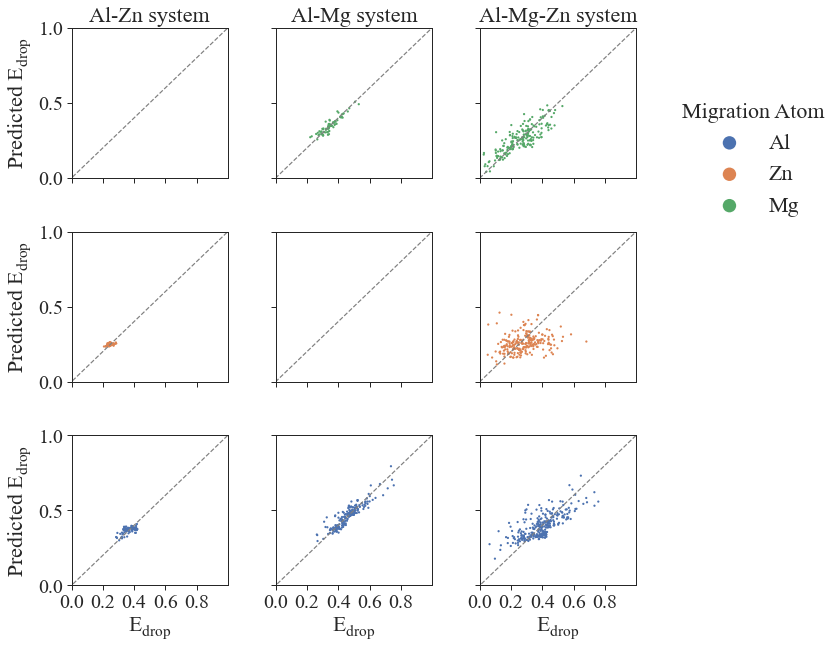

In [95]:
coef_dict=dict()
for atom in ['Al', 'Mg', 'Zn']:
    coef_subdict=dict()
    for system in ['Al-Zn', 'Al-Mg', 'Al-Mg-Zn']:
        cond = (df['migration_atom']==atom) & (df['migration_system']==system)
        df_it = df[cond]
        if len(df_it) == 0:
            continue
        x = np.stack([np.ones(len(df_it)), df_it['energy_difference'], df_it['min_erg_distance']]).T
        y = np.stack(df_it['e_drop']).reshape(-1,1)
        b = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
        coef_subdict[system] = b
    coef_dict[atom]=coef_subdict
    
def GetPredEDrop(row):
    b = coef_dict[row['migration_atom']][row['migration_system']]
    return b[0] + row['energy_difference']*b[1] + row['min_erg_distance']*b[2]
df['e_drop_predicted'] = df.apply(lambda row: GetPredEDrop(row), axis=1)

error = mean_squared_error(df['e_drop_predicted'], df['e_drop'])
print(f"MSE of E drop {error}")
xlim_range = [0, 1]
ylim_range = [0, 1]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"], row_order=["Mg","Zn","Al"], col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'],
                  margin_titles=False, sharey=True, ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="e_drop", y="e_drop_predicted",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})
for i in range(3):
    g.axes[i,0].set_ylabel(r'Predicted $\mathregular{E_{drop}}$')

for ax in g.axes.flat:
    ax.set_title('')
    xx =  np.linspace(-1, 1, num=1000)
    ax.plot(xx, xx, color='grey', ls='--')
g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')

for ax in g.axes.flatten():
    ax.set_xticks(np.arange(0, 1, 0.2))
for ax in g.axes[2]:
    ax.set_xlabel(r'$\mathregular{E_{drop}}$')
g.despine(top=False, right=False)

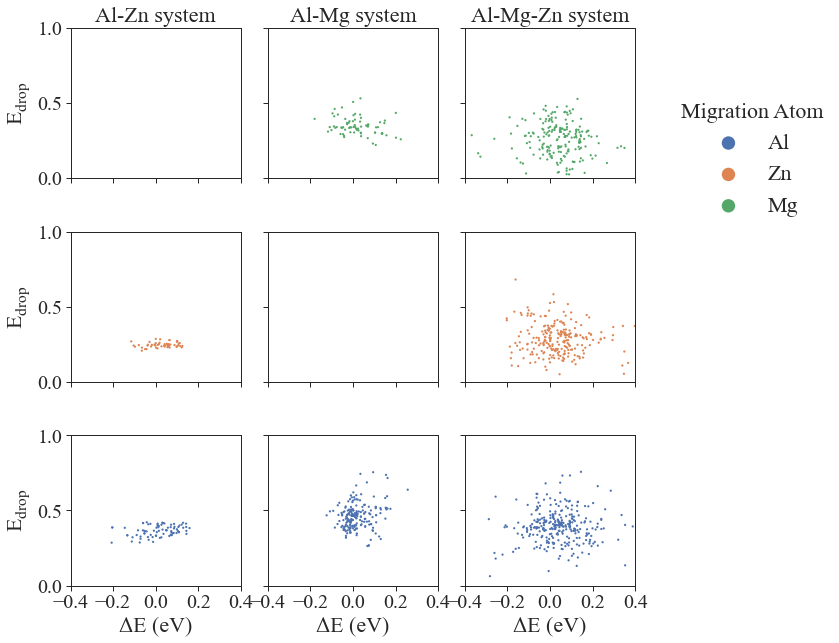

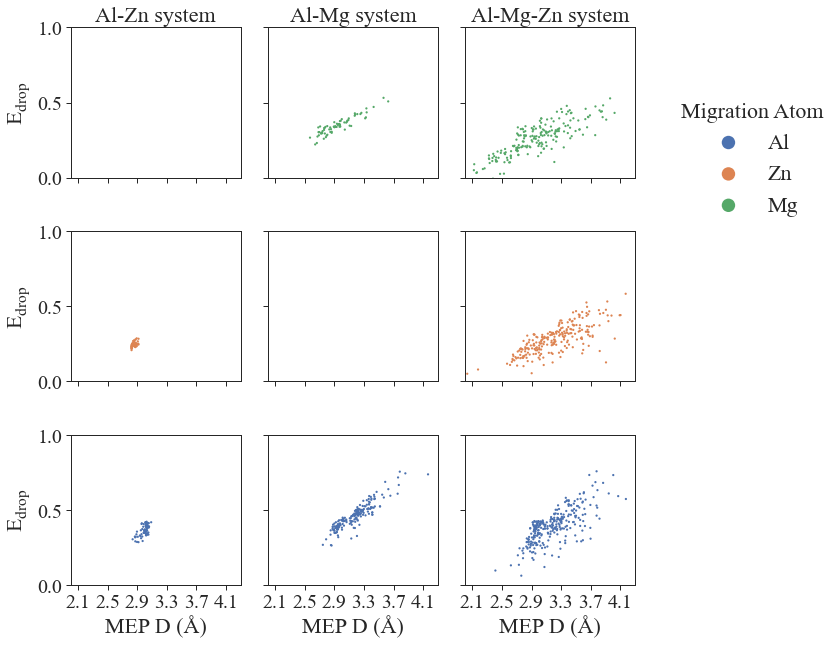

In [6]:
xlim_range = [-0.4, 0.4]
ylim_range = [0, 1]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"], row_order=["Mg","Zn","Al"], col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'],
                  margin_titles=False, sharey=True, ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="energy_difference", y="e_drop",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})
for i in range(3):
    g.axes[i,0].set_ylabel(r'$\mathregular{E_{drop}}$')
g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')
for i in range(1,3):
    for j in range(3):
        g.axes[i,j].set_title('')
for ax in g.axes.flatten():
    ax.set_xticks(np.arange(-0.4,0.45,0.2))
for ax in g.axes[2]:
    ax.set_xlabel('ΔE (eV)')
g.despine(top=False, right=False)
##############################################################################################################################
xlim_range = [2.0, 4.3]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"], row_order=["Mg","Zn","Al"], col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'],
                  margin_titles=False, sharey=True, ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="min_erg_distance", y="e_drop",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})
for i in range(3):
    g.axes[i,0].set_ylabel(r'$\mathregular{E_{drop}}$')
g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')
for i in range(1,3):
    for j in range(3):
        g.axes[i,j].set_title('')
for ax in g.axes.flatten():
    ax.set_xticks(np.arange(2.1, 4.3, 0.4))
for ax in g.axes[2]:
    ax.set_xlabel('MEP D (Å)')
g.despine(top=False, right=False)

## Landau theory

$$E=\delta D^4 + \gamma D^3 + \beta D^2$$

$$\frac{\partial E}{\partial D} = 4\delta D^3 + 3\gamma D^2 + 2\beta D$$
$$\frac{\partial^2 E}{\partial D^2} = 12\delta D^2 + 6\gamma D + 2\beta$$
Equation set
$$
\begin{pmatrix}
D_{end}^4 & D_{end}^3 & D_{end}^2 \\
4D_{end}^3 & 3D_{end}^2 & 2D_{end} \\
D_{tran}^4 & D_{tran}^3 & D_{tran}^2 
\end{pmatrix}
\begin{pmatrix}
\delta\\ 
\gamma\\
\beta
\end{pmatrix} = 
\begin{pmatrix}
E_{end}\\ 
0\\
E_{tran}
\end{pmatrix}
$$
e.i.
$$Ax=b$$

In [178]:
df = pd.read_pickle('../data/processed/linear_regression.pkl')
df = df[0:-1:2]
def Get3ptsLandauFit(row):
    distance_list = row["distance_list"]
    energy_list = row["energy_list"]
    E_end = energy_list[-1]
    D_end = distance_list[-1]
    i = np.argmax(energy_list)

    E_tran = energy_list[i]
    D_tran = distance_list[i]
    A = np.array([[D_end**4, D_end**3, D_end**2], 
                  [4*D_end**3, 3*D_end**2, 2*D_end], 
                  [D_tran**4, D_tran**3, D_tran**2]])
    b = np.array([E_end, 0, E_tran])
    
    return np.linalg.solve(A, b)
df['Landau_coef']=df.apply(lambda row: Get3ptsLandauFit(row), axis=1)

In [179]:
# def CalculateRemainingForce(row):
#     distance_list = row["distance_list"]
#     energy_list = row["energy_list"]
#     i = np.argmax(energy_list)
#     D_tran = distance_list[i]
#     delta, gamma, beta = row['Landau_coef']
#     return 4*delta*D_tran**3 + 3*gamma*D_tran**2 + 2*beta*D_tran

# df['remaining_f']= df.apply(lambda row: CalculateRemainingForce(row), axis=1)

# fig, ax = plt.subplots(1,1,figsize=(10, 10))
# ax.plot(df['saddle_force'], df['remaining_f'],marker='o', linestyle='', ms=3)
# ax.set_xlabel('NEB Saddle Force', fontdict={'family' : 'Times New Roman', 'size':20})
# ax.set_ylabel('Remaining Force', fontdict={'family' : 'Times New Roman', 'size':20})

In [180]:
def GetEDrop(row):
    delta, gamma, beta = row['Landau_coef']
    D = row['min_erg_distance']
    
    a1 = beta
    a2 = beta+6*delta*D**2+3*gamma*D
    b1 = 0
    b2 = -2*a2*D
    c1 = 0
    c2 = a2*np.power(D, 2) + row['energy_difference']
    sq_delta = np.sqrt(np.power((b2-b1), 2)-4*(a2-a1)*(c2-c1))
    x1 = ((b1-b2)-sq_delta)/2/(a2-a1)
    
    energy = a1*x1**2 + b1*x1 + c1
    e_drop = energy - np.max(row['energy_list'])
    return e_drop
df['e_drop'] = df.apply(lambda row: GetEDrop(row), axis=1)


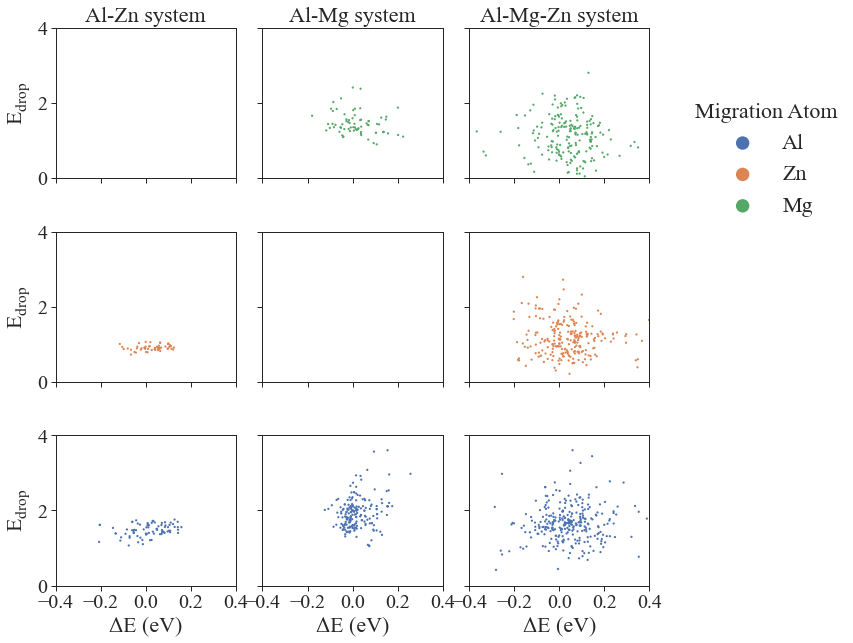

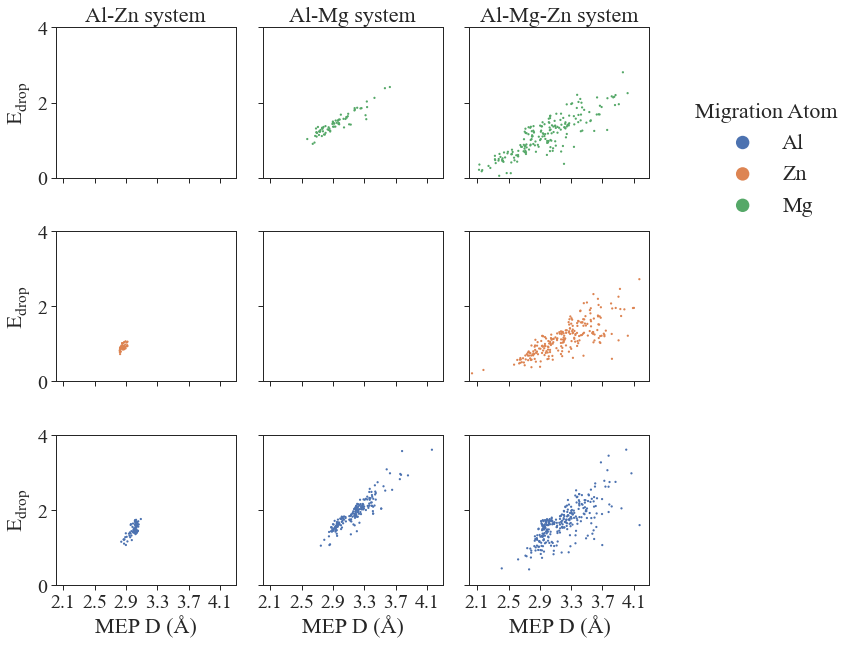

In [181]:
xlim_range = [-0.4, 0.4]
ylim_range = [0, 4]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"], row_order=["Mg","Zn","Al"], col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'],
                  margin_titles=False, sharey=True, ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="energy_difference", y="e_drop",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})
for i in range(3):
    g.axes[i,0].set_ylabel(r'$\mathregular{E_{drop}}$')
g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')
for i in range(1,3):
    for j in range(3):
        g.axes[i,j].set_title('')
for ax in g.axes.flatten():
    ax.set_xticks(np.arange(-0.4,0.45,0.2))
for ax in g.axes[2]:
    ax.set_xlabel('ΔE (eV)')
g.despine(top=False, right=False)
##############################################################################################################################
xlim_range = [2.0, 4.3]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"], row_order=["Mg","Zn","Al"], col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'],
                  margin_titles=False, sharey=True, ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="min_erg_distance", y="e_drop",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})
for i in range(3):
    g.axes[i,0].set_ylabel(r'$\mathregular{E_{drop}}$')
g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')
for i in range(1,3):
    for j in range(3):
        g.axes[i,j].set_title('')
for ax in g.axes.flatten():
    ax.set_xticks(np.arange(2.1, 4.3, 0.4))
for ax in g.axes[2]:
    ax.set_xlabel('MEP D (Å)')
g.despine(top=False, right=False)

MSE of E drop 0.24796969604413233


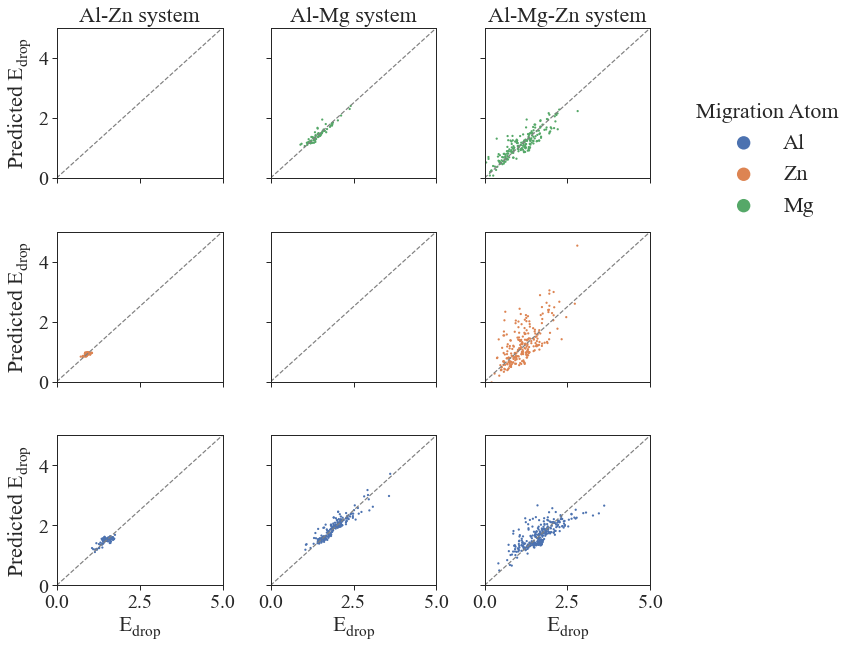

In [182]:
coef_dict=dict()
for atom in ['Al', 'Mg', 'Zn']:
    coef_subdict=dict()
    for system in ['Al-Zn', 'Al-Mg', 'Al-Mg-Zn']:
        cond = (df['migration_atom']==atom) & (df['migration_system']==system)
        df_it = df[cond]
        if len(df_it) == 0:
            continue
        x = np.stack([np.ones(len(df_it)), df_it['energy_difference'], df_it['energy_difference']**2, df_it['min_erg_distance'], df_it['min_erg_distance']**2]).T
        y = np.stack(df_it['e_drop']).reshape(-1,1)
        b = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
        coef_subdict[system] = b
    coef_dict[atom]=coef_subdict
    
def GetPredEDrop(row):
    b = coef_dict[row['migration_atom']][row['migration_system']]
    return b[0] + b[1]*row['energy_difference'] + b[2]*row['energy_difference']**2 + b[3]*row['min_erg_distance'] + b[4]*row['min_erg_distance']**2
df['e_drop_predicted'] = df.apply(lambda row: GetPredEDrop(row), axis=1)

error = mean_squared_error(df['e_drop_predicted'], df['e_drop'])
print(f"MSE of E drop {error}")
xlim_range = [0, 5]
ylim_range = [0, 5]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"], row_order=["Mg","Zn","Al"], col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'],
                  margin_titles=False, sharey=True, ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="e_drop", y="e_drop_predicted",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})
for i in range(3):
    g.axes[i,0].set_ylabel(r'Predicted $\mathregular{E_{drop}}$')

for ax in g.axes.flat:
    ax.set_title('')
    xx =  np.linspace(-1, 20, num=1000)
    ax.plot(xx, xx, color='grey', ls='--')
g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')

# for ax in g.axes.flatten():
#     ax.set_xticks(np.arange(0, 20, 5))
for ax in g.axes[2]:
    ax.set_xlabel(r'$\mathregular{E_{drop}}$')
g.despine(top=False, right=False)

In [226]:
for i, row in enumerate(df.iterrows()):
    fig, ax = plt.subplots(1,1,figsize=(10, 10))
    
    # Two parabolas
    delta, gamma, beta = row[1]['Landau_coef'] 
    dE = row[1]['energy_difference']
    D = row[1]['min_erg_distance']
    a1 = beta
    a2 = beta+6*delta*D**2+3*gamma*D
    b1 = 0
    b2 = -2*a2*D
    c1 = 0
    c2 = a2*np.power(D, 2) + row[1]['energy_difference']
    sq_delta = np.sqrt(np.power((b2-b1), 2)-4*(a2-a1)*(c2-c1))
    x1 = ((b1-b2)-sq_delta)/2/(a2-a1)
    energy = a1*x1**2 + b1*x1 + c1

    xx = np.linspace(-1, row[1]['min_erg_distance']+1)
    ax.plot(xx, a1*xx**2 + b1*xx + c1, linestyle='-', ms=3, color='green')
    ax.plot(xx, a2*xx**2 + b2*xx + c2, linestyle='-', ms=3, color='green')

    
    # Fitted quartic curve
    ax.plot(row[1]['distance_list'], row[1]['energy_list'],marker='o', linestyle='', ms=3)
    ax.plot(xx, delta*xx**4 + gamma*xx**3 + beta*xx**2, linestyle='-', ms=3, color='blue')
    
    # Calculated curve
    def u_ij(z):
        x = z/D
        return (x - x**2)**2 * ((1 - x) * a1*(D*D) + x * a2*(D*D)) + \
                x ** 3 * (6 * x**2 - 15 * x + 10) * dE
    print(6*dE/(D**2)+(a2-a1))
    ax.plot(xx, u_ij(xx), linestyle='-', ms=3, color='red')

    ax.set_xlim([-1.1, D+1.1])
    ax.set_ylim([np.min(row[1]['energy_list'])-0.2,energy+0.2 ])

    ax.set_xlabel('MEP D (Å)', fontdict={'family' : 'Times New Roman', 'size':20})
    ax.set_ylabel('E (eV)', fontdict={'family' : 'Times New Roman', 'size':20})
    plt.savefig(f'fig1/{i}.png')
    plt.close(fig)


-3.635980405647388e-15
4.579669976578771e-16
2.42861286636753e-15
3.95516952522712e-15
2.9524993561125257e-15
1.7139067942650854e-15
-1.1934897514720433e-15
-5.898059818321144e-16
-6.106226635438361e-16
3.677613769070831e-15
2.768618667658984e-15
2.4702462297909733e-15
2.3939183968479938e-15
-1.0824674490095276e-15
-2.456368441983159e-15
-1.2698175844150228e-15
-2.1094237467877974e-15
2.8727020762175925e-15
-2.572594914873605e-15
1.5092094240998222e-16
1.6237011735142914e-15
-3.9065972678997696e-15
-1.0269562977782698e-15
-2.71657696337968e-15
7.91033905045424e-16
9.020562075079397e-17
-1.2351231148954867e-15
-1.1518563880486e-15
2.761679773755077e-15
1.4155343563970746e-15
6.245004513516506e-16
4.85722573273506e-16
2.048274744259615e-15
1.3114509478384662e-15
-3.3306690738754696e-16
-8.743006318923108e-16
2.7755575615628914e-16
1.6930901125533637e-15
1.942890293094024e-16
3.7539416020138106e-15
0.0
-3.969047313034935e-15
-1.5612511283791264e-16
-6.938893903907228e-17
-2.19269047363468

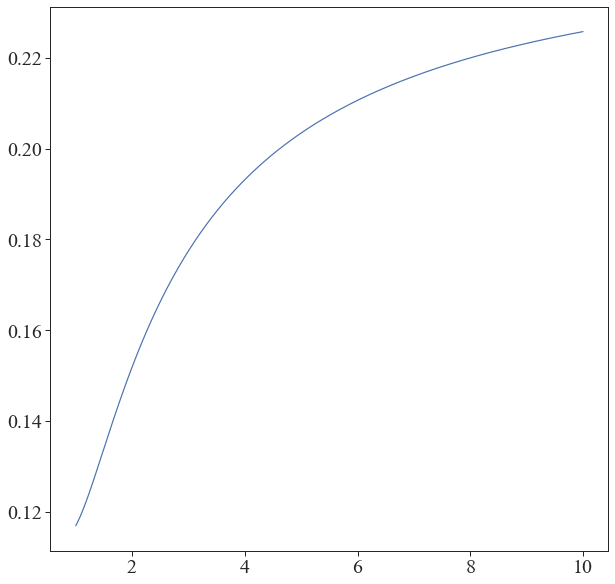

In [209]:
a1, a2 = 1, 1


#     def u_i(z):
#         x = z/D
#         return a1*D*D * x ** 2

#     def u_j(z):
#         x = z/D
#         return a2*D*D * (x - 1) ** 2 + dE

#     def u_ij(z):
#         x = z/D
#         return (x - x ** 2) ** 2 * ((1 - x) * a1*D*D + x * a2*D*D) + \
#                 x ** 3 * (6 * x**2 - 15 * (x) + 10) * dE
def GetE(D, dE):
    coef = np.array([
        -2.5 * (6 * dE + a2*D*D - a1*D*D),
        2.5 * (6 * dE + a2*D*D - a1*D*D) - a1*D*D - a2*D*D,
        a1*D*D
    ])
    roots = np.roots(coef)

    r = roots[0] if 0 <= roots[0] <= 1 else roots[1]
    Qt = u_ij(r)
    return Qt

def GetEDrop(D):
    coef = np.array([
        -2.5 * (6 * dE + a2*D*D - a1*D*D),
        2.5 * (6 * dE + a2*D*D - a1*D*D) - a1*D*D - a2*D*D,
        a1*D*D
    ])
    roots = np.roots(coef)

    r = roots[0] if 0 <= roots[0] <= 1 else roots[1]
    Qt = u_ij(r)
    return Qt

root_list = []
for D in np.linspace(1, 100,1000):
    root_list.append(GetE(D, 0))
fig, ax = plt.subplots(1,1,figsize=(10, 10))
ax.plot(np.linspace(1, 100,1000),root_list, linestyle='-', ms=3)



## Landau theory 2
$$E=\delta D^4 + \gamma D^3 + \beta D^2 + \alpha D + C$$

$$\frac{\partial E}{\partial D} = 4\delta D^3 + 3\gamma D^2 + 2\beta D + \alpha$$
$$\frac{\partial^2 E}{\partial D^2} = 12\delta D^2 + 6\gamma D + 2\beta$$

Equation set
$$
\begin{pmatrix}
D_{start}^4 & D_{start}^3 & D_{start}^2 & D_{start} & 1 \\
\vdots & \vdots & \vdots \\
D_{end}^4 & D_{end}^3 & D_{end}^2 & D_{end} & 1 \\
4D_{start}^3 & 3D_{start}^2 & 2D_{start} & 1 & 0\\
4D_{tran}^3 & 3D_{tran}^2 & 2D_{tran} & 1 & 0\\
4D_{end}^3 & 3D_{end}^2 & 2D_{end} & 1 & 0
\end{pmatrix}
\begin{pmatrix}
\delta\\ 
\gamma\\
\beta\\
\alpha\\
C
\end{pmatrix} = 
\begin{pmatrix}
E_{start}\\ 
\vdots\\
E_{tran}\\
0\\0\\0
\end{pmatrix}
$$
e.i.
$$Ax=b$$

In [165]:
df = pd.read_pickle('../data/processed/linear_regression.pkl')
df = df[0:-1:2]

In [166]:
def Get3ptsLandauFit(row):
    distance_list = np.array(row["distance_list"]).reshape(-1,1)
    energy_list = np.array(row["energy_list"]).reshape(-1,1)
    i = np.argmax(energy_list)
    dist_3pts = np.array([distance_list[0], distance_list[i], distance_list[-1]]).reshape(-1,1)
    A1 = np.hstack((distance_list**4, distance_list**3, distance_list**2, distance_list, distance_list**0))
    A2 = np.hstack((4*dist_3pts**3, 3*dist_3pts**2, 2*dist_3pts, dist_3pts**0, np.zeros(dist_3pts.shape)))
    A = np.vstack((A1, A2))
    b = np.array(list(row["energy_list"])+[0,0,0])
    W = np.diag([20,5,5,5,5,5,20,2,1,2])
    
    return np.linalg.inv(A.T.dot(W).dot(A)).dot(A.T).dot(W).dot(b)
df['Landau_coef']=df.apply(lambda row: Get3ptsLandauFit(row), axis=1)

In [167]:
# for i, row in enumerate(df.iterrows()):
#     coef = row[1]['Landau_coef']
#     xx = np.linspace(0, row[1]['min_erg_distance'], 1000).reshape(-1,1)
#     A = np.hstack((xx**4, xx**3, xx**2, xx, xx**0))
#     fig, ax = plt.subplots(1,1,figsize=(10, 10))
#     ax.plot(row[1]['distance_list'], row[1]['energy_list'],marker='o', linestyle='', ms=3)
    
    
#     ax.plot(xx, A.dot(coef), linestyle='-', ms=3)

#     ax.set_xlabel('MEP D (Å)', fontdict={'family' : 'Times New Roman', 'size':20})
#     ax.set_ylabel('E (eV)', fontdict={'family' : 'Times New Roman', 'size':20})
#     plt.savefig(f'fig2/{i}.png')
#     plt.close(fig)

In [168]:
def GetEDrop(row):
    delta, gamma, beta, alpha, C = row['Landau_coef']
    D = row['min_erg_distance']
    
    a1 = beta + alpha/2
    a2 = beta+6*delta*D**2+3*gamma*D
    b1 = alpha
    b2 = -8*delta*D**3-3*gamma*D**2+alpha
    c1 = C
    c2 = delta*D**4 + gamma*D**3 + beta*D**2 + alpha*D + C - a2*D**2 - b2*D
    
    sq_delta = np.sqrt(np.power((b2-b1), 2)-4*(a2-a1)*(c2-c1))
    x1 = ((b1-b2)-sq_delta)/2/(a2-a1)
    
    energy = a1*x1**2 + b1*x1 + c1
    e_drop = energy - np.max(row['energy_list'])
    return e_drop
df['e_drop'] = df.apply(lambda row: GetEDrop(row), axis=1)


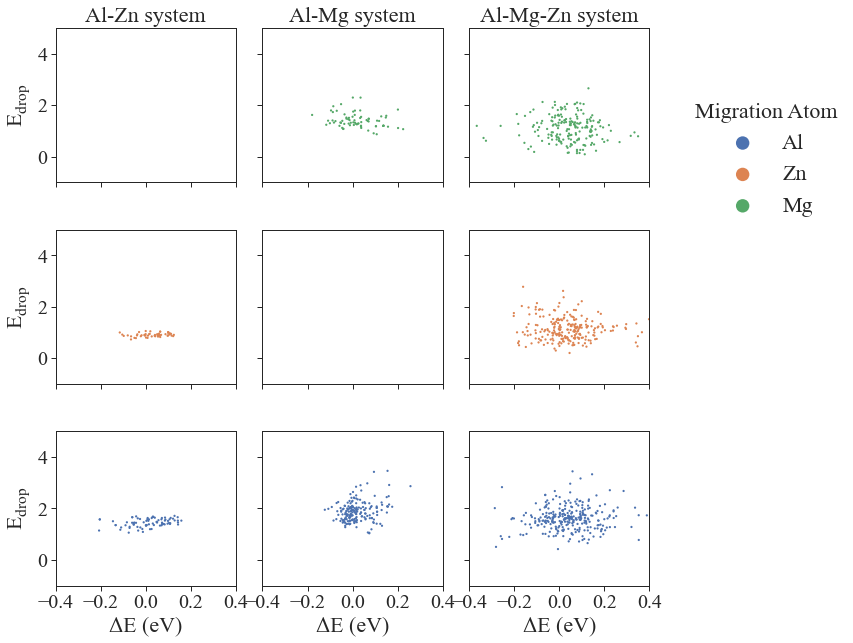

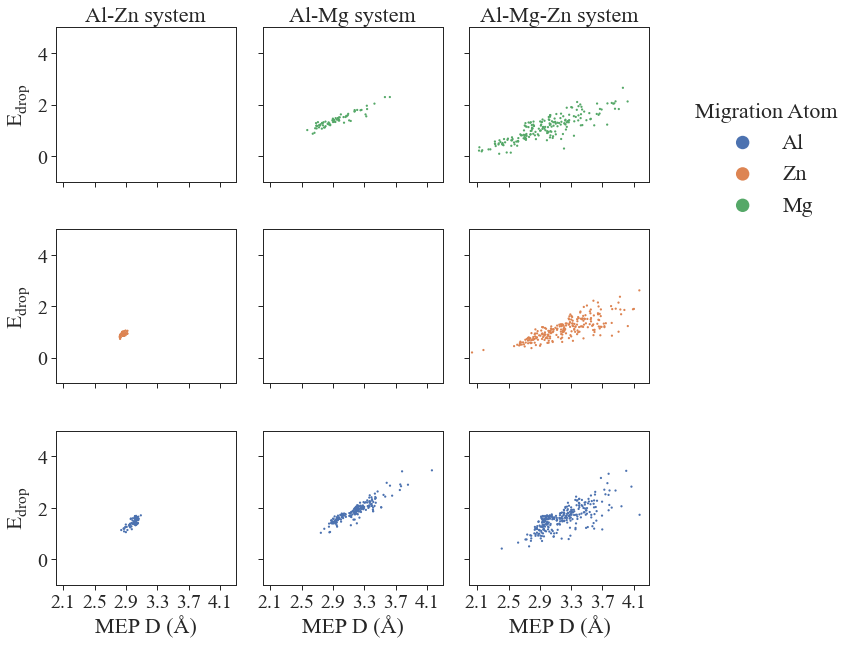

In [169]:
xlim_range = [-0.4, 0.4]
ylim_range = [-1, 5]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"], row_order=["Mg","Zn","Al"], col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'],
                  margin_titles=False, sharey=True, ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="energy_difference", y="e_drop",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})
for i in range(3):
    g.axes[i,0].set_ylabel(r'$\mathregular{E_{drop}}$')
g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')
for i in range(1,3):
    for j in range(3):
        g.axes[i,j].set_title('')
for ax in g.axes.flatten():
    ax.set_xticks(np.arange(-0.4,0.45,0.2))
for ax in g.axes[2]:
    ax.set_xlabel('ΔE (eV)')
g.despine(top=False, right=False)
##############################################################################################################################
xlim_range = [2.0, 4.3]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"], row_order=["Mg","Zn","Al"], col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'],
                  margin_titles=False, sharey=True, ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="min_erg_distance", y="e_drop",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})
for i in range(3):
    g.axes[i,0].set_ylabel(r'$\mathregular{E_{drop}}$')
g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')
for i in range(1,3):
    for j in range(3):
        g.axes[i,j].set_title('')
for ax in g.axes.flatten():
    ax.set_xticks(np.arange(2.1, 4.3, 0.4))
for ax in g.axes[2]:
    ax.set_xlabel('MEP D (Å)')
g.despine(top=False, right=False)

[[-4.84406745  0.17466363  2.09853082]]
[[-3.38822887 -0.5711102   1.65868897]]
[[-2.15922124  0.02821017  1.18250412]]
[[-1.96747471 -0.08676088  1.14628901]]
[[-1.9191755   0.23408276  1.0120441 ]]
[[-2.9563431   0.19634749  1.3493551 ]]
[[-2.33565657 -1.27794553  1.09766699]]
MSE of E drop 0.0763103137739973


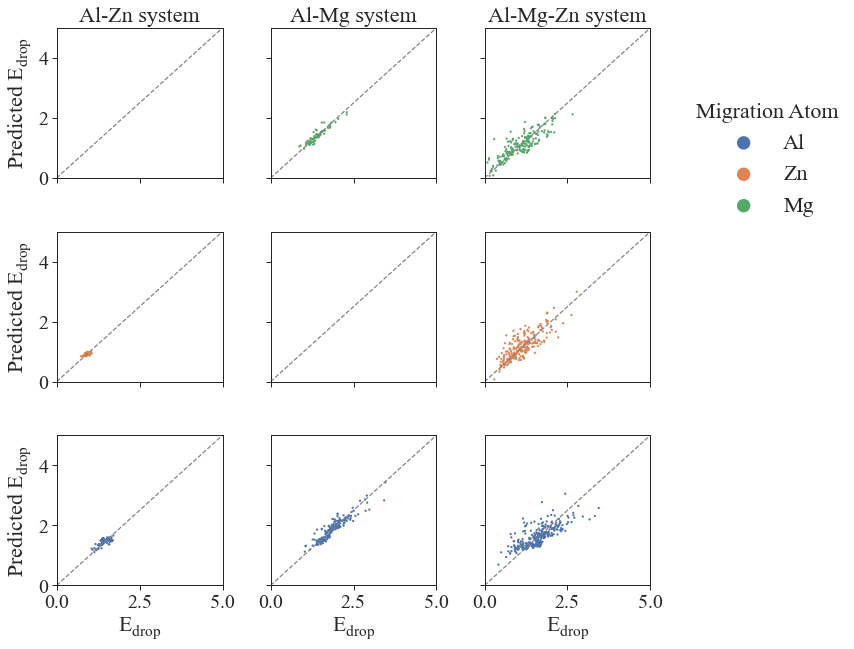

In [176]:
coef_dict=dict()
for atom in ['Al', 'Mg', 'Zn']:
    coef_subdict=dict()
    for system in ['Al-Zn', 'Al-Mg', 'Al-Mg-Zn']:
        cond = (df['migration_atom']==atom) & (df['migration_system']==system)
        df_it = df[cond]
        if len(df_it) == 0:
            continue
        x = np.stack([np.ones(len(df_it)), df_it['energy_difference'], df_it['min_erg_distance']]).T
        y = np.stack(df_it['e_drop']).reshape(-1,1)
        b = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
        coef_subdict[system] = b
    coef_dict[atom]=coef_subdict
    
def GetPredEDrop(row):
    b = coef_dict[row['migration_atom']][row['migration_system']]
    return b[0] + row['energy_difference']*b[1] + row['min_erg_distance']*b[2]

df['e_drop_predicted'] = df.apply(lambda row: GetPredEDrop(row), axis=1)

error = mean_squared_error(df['e_drop_predicted'], df['e_drop'])
print(f"MSE of E drop {error}")
xlim_range = [0, 5]
ylim_range = [0, 5]
sns.set(font='Times New Roman',style='ticks')
sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":22,"axes.labelsize":22,"xtick.labelsize":20,"ytick.labelsize":20,}) 
palette ={"Al": "C0", "Zn": "C1", "Mg": "C2"}
g = sns.FacetGrid(df, col="migration_system", legend_out= True, row="migration_atom", hue="migration_atom",
                  hue_order=["Al","Zn","Mg"], row_order=["Mg","Zn","Al"], col_order=['Al-Zn', 'Al-Mg', 'Al-Mg-Zn'],
                  margin_titles=False, sharey=True, ylim=ylim_range, xlim=xlim_range, palette=palette)
marker = matplotlib.markers.MarkerStyle('o',fillstyle='full')
g = g.map_dataframe(plt.scatter, x="e_drop", y="e_drop_predicted",  alpha=1, s=5, marker=marker, edgecolors='none')
g = g.add_legend(loc='upper center', bbox_to_anchor=(1, .85), markerscale=6, scatterpoints=1, label_order=['Al', 'Zn', 'Mg'], prop={'size':22})
g._legend.set_title('Migration Atom', prop={'size':22})
for i in range(3):
    g.axes[i,0].set_ylabel(r'Predicted $\mathregular{E_{drop}}$')

for ax in g.axes.flat:
    ax.set_title('')
    xx =  np.linspace(-1, 20, num=1000)
    ax.plot(xx, xx, color='grey', ls='--')
g.axes[0,0].set_title('Al-Zn system')
g.axes[0,1].set_title('Al-Mg system')
g.axes[0,2].set_title('Al-Mg-Zn system')

# for ax in g.axes.flatten():
#     ax.set_xticks(np.arange(0, 20, 5))
for ax in g.axes[2]:
    ax.set_xlabel(r'$\mathregular{E_{drop}}$')
g.despine(top=False, right=False)

In [122]:
coefs = np.stack(df['Landau_coef'])
df['delta'] = coefs[:,0]
df['gamma'] = coefs[:,1]
df['beta'] = coefs[:,2]
df['alpha'] = coefs[:,3]
df['C'] = coefs[:,4]